# Computer Vision Model for "What is the weather like outside?"

**In this notebook we will be looking at a working model that will tell us the weather in any image.**

This notebook will take you though each step used to make a working model, that can detect the weather.
The process will be broken into parts so that everyone can understand the process I used to make this happen.

The First thing we need is some libraries, that will help make this process work.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Once we have the libraries load we can take in a test image for the process.

In [2]:
img = cv2.imread('C:\\Users\\robert\\Documents\\Bob College work\\Year 4\\Project\\Images\\test4.jpg')

Next we should do a few conversions on the image. Things like:
- Convert BGR to RGB
- Convert BGR to HSV

These colour formats will be need later on in the process.

In [3]:
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Now that the starting formalities are done, we must start the building of the process.

The first thing we need to do is resize the image.

In [4]:
Z = img.reshape((-1,3))

We then want use the resize image pixels as a array for the kmeans algorithm.

In [5]:
Z = np.float32(Z)

Next we are going to use K means technique on the resize image.
The following line of code sets the define criteria, number of clusters(K) and apply kmeans.

In [6]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

Now set the K value.

In [7]:
K = 2

We can now use the K means algorithm.

In [8]:
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

Lovely, Now we want to convert the result back into uint8, and then mask the image.

In [9]:
center = np.uint8(center)
res = center[label.flatten()]

Next we want to bring the image back to normal size for the next steps.

In [10]:
res2 = res.reshape((img.shape))

Now that we have the image back to size, we can show the results of the kmeans.

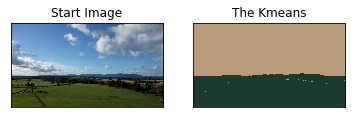

In [11]:
plt.subplot(1,2,1),plt.imshow(imgRGB)
plt.title('Start Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res2)
plt.title('The Kmeans'), plt.xticks([]), plt.yticks([])
plt.show()

A we have a nice split across the image, we can see that there is two main areas. 

We now want to use that result to move.

OK, the next step is to convert the above result to Hue, Saturation and Value form for the colour finder to work.

In [12]:
hsv = cv2.cvtColor(res2, cv2.COLOR_BGR2HSV)

The next few steps will be setting the range of colour we are looking for, the colour we will be looking at is:
- Black
- White
- Red
- Green
- Blue
- Gray

Once we set the range we will then place a mask on the values. This is so we can use the results to affect the current image.
Making the sky more prominent.

First we do Black

In [13]:
BLACK = np.array([0,0,0],np.uint8)
blackRange = cv2.inRange(hsv,BLACK,BLACK)

Because black has no real range, we must use countNonZero to find the non black pixels of that range.

In [14]:
no_black_pixels = cv2.countNonZero(blackRange)

Next's is Red.

In [15]:
lower_red = np.array([40,0,0], dtype=np.uint8)
high_red = np.array([255,100,100], dtype=np.uint8)
# set mask of the above range
red_mask = cv2.inRange(hsv, lower_red, high_red)

Green is next.

In [16]:
lower_green = np.array([0,40,0], dtype=np.uint8)
high_green = np.array([100,255,100], dtype=np.uint8)
# set mask of the above range
green_mask = cv2.inRange(hsv, lower_green, high_green)

Now Blue

In [17]:
lower_blue = np.array([0,0,40], dtype=np.uint8)
upper_blue = np.array([100,100,255], dtype=np.uint8)
# set mask of the above range
blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

We now want the White range.

In [18]:
lower_white = np.array([127,127,127], dtype=np.uint8)
upper_white = np.array([255,255,255], dtype=np.uint8)
# set mask of the above range
white_mask = cv2.inRange(hsv, lower_white, upper_white)

And we finish with Gray.

In [19]:
lower_grey = np.array([90,0,0], dtype=np.uint8)
upper_grey = np.array([130,255,125], dtype=np.uint8)
# set mask of the above range
mask = cv2.inRange(hsv, lower_grey, upper_grey)

Now that we have all the range values we need, we need use countNonZero on them, first we have the gray value.

That should be straightforward we do as we did with the black range.

In [20]:
no_grey_pixels = cv2.countNonZero(mask)

Next is the hard part, we want to find the sky blues and whites, but noting else. 

So we need to find a formula that can best fit the process, there was a lot of trial and error here, but this was the best i could come up with.

In [21]:
total_mask = ((red_mask - green_mask - blue_mask) + white_mask)

Now find the non blue pixels with the countNonZero call.

In [22]:
no_blue_pixels = cv2.countNonZero(total_mask)

Last we want to use bitwise_not to show the results on the original images.

In [23]:
results = cv2.bitwise_not(img,img, mask= total_mask)

OK, lets see what that did?

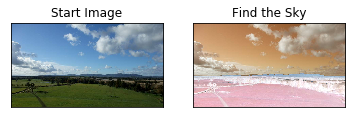

In [24]:
plt.subplot(1,2,1),plt.imshow(imgRGB)
plt.title('Start Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(results)
plt.title('Find the Sky'), plt.xticks([]), plt.yticks([])
plt.show()

Ok the ground is white and should not affect the outcome, we can see the sky clear now.

Next if want to focus on the colours and output a message on what level of blue or gray is in the sky.

There are two things we need to do before we carry on, first we need to calculate the total amount of pixels in the image.
Then we need to find the total amount of pixels in the sky.

In [25]:
total_pixels = img.size / 3

In [26]:
sky_region_pixels = total_pixels - no_black_pixels

**Now that we have the area of the image we need, we can build a output from the results.**

To do this we will use the number of pixels in the blue and gray mask to calcuate the sky.

First i will take the number of gray pixels and build a if statment to represent the amount of gray in the sky. From that result I will output messages to say what the weather is like from the range of gray.

Then I take the blue pixels and do the same thing, these both we show the different types of weather you would normal have.

In [27]:
if no_grey_pixels == 0 and no_blue_pixels == 0:
    print("Sorry no blue or gray pixels found in the image.")
elif no_grey_pixels > no_blue_pixels:
    grey_percentage = (no_grey_pixels / sky_region_pixels) * 100
    print("The percentage of grey in the sky region is : " 
          + str(grey_percentage))
    print("The number of pixels of the sky region is : " 
          + str(sky_region_pixels))
    if grey_percentage > 70:
        print("It is definitely going to rain today!\n")
    elif grey_percentage > 50 and grey_percentage <= 70:
        print("Well there is a good chance you will get wet, \
              if you go out in that weather!\n")
    elif grey_percentage > 30 and grey_percentage <= 50:
        print("Some Heavy clouds, with a chances of rain!\n")
    elif grey_percentage > 9 and grey_percentage <= 30:
        print("Scattered rain in main places.\n")
    else:
        print("It will be a grand overcast day!\n")
elif no_blue_pixels > no_grey_pixels:
    blue_percentage = (no_blue_pixels / sky_region_pixels) * 100
    print("The number of blue pixels is: " + str(no_blue_pixels))
    print("The number of pixels of the sky region is : " 
          + str(sky_region_pixels))
    print("The percentage of blue in the sky region is : " 
          + str(blue_percentage))
    if blue_percentage > 90:
        print("It fell like spain out there!\n")
    elif blue_percentage > 70 and blue_percentage <= 90:
        print("God that is a lovely sunny day.\n")
    elif blue_percentage > 50 and blue_percentage <= 70:
        print("It is a good Irish Summer day.\n")
    elif blue_percentage > 30 and blue_percentage <= 50:
        print("It's a nice came day.\n")
    elif blue_percentage > 10 and blue_percentage <= 30:
        print("It is Cloudy out there today.\n")
    else:
        print ("It's a dull day today")
else:
    print("I Don't Know, I Can't See The Sky")

The number of blue pixels is: 168762
The number of pixels of the sky region is : 450000.0
The percentage of blue in the sky region is : 37.50266666666667
It's a nice came day.



**As you can see we got a result that is accuate to what is in the image.**

Now the code got it right for that one but it doesn't do it for everyone I enter.

After research the problem more, I found that not all divide the way we need, for example:
- If there is more green or red pixels in the image, it mess up the mask calcuations. Therefor affecting the sky area, this in turn give mixs result if any.

For this reason the outcomes can be hit and miss on any given image. 